This file is used to predict joule heating and total hemispheric power with the smrai3 (LSTM) model

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy import interpolate
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import datetime as datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr

import torch
import torch.nn as nn

#27-09-24 Sachin Reddy


In [42]:
def open_omni():
    df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
    #df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
    
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)
    
    df['Timestamp_1min_omni'] = pd.to_datetime(df['Timestamp_1min_omni'])
    
    #df = df[df['Timestamp_1min_omni'] == '1999-10-22 05:50:00']
    df = df[df['Timestamp_1min_omni'].between('1999-10-22 02:30:00', '1999-10-22 08:00:00')]
    #df = df[df['Timestamp_1min_omni'].between('2004-01-01 00:00:00', '2004-12-31 23:59:59')]
    #df = df[df['Timestamp_1min_omni'].between('1999-10-21 21:00:00', '1999-10-23 00:00:00')]

    #Weimer comparison
    #df = df[df['Timestamp_1min_omni'].between('1995-10-18 15:00:00', '1995-10-19 00:00:00')]
    
    df = df.set_index('Timestamp_1min_omni')
    #df = df.resample('1h').mean(numeric_only=True)
    df = df.reset_index()

    return df

omni_data = open_omni()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1999-10-22 02:30:00,-11.61,-9.230000,474,7.360000,457,-368,89,1999-10-22 02:00:00,158,7.0,-0.346152
1,1999-10-22 02:35:00,-10.31,-11.260000,482,8.940000,458,-364,94,1999-10-22 02:00:00,158,7.0,-0.348217
2,1999-10-22 02:40:00,-6.51,-16.309999,481,8.360000,402,-320,82,1999-10-22 02:00:00,158,7.0,-0.350205
3,1999-10-22 02:45:00,-4.79,-18.600000,469,10.660000,418,-368,50,1999-10-22 02:00:00,158,7.0,-0.352114
4,1999-10-22 02:50:00,-10.07,-13.220000,493,6.480000,382,-293,90,1999-10-22 02:00:00,158,7.0,-0.353943
...,...,...,...,...,...,...,...,...,...,...,...,...
62,1999-10-22 07:40:00,10.16,4.930000,612,35.279999,360,-291,69,1999-10-22 07:00:00,158,8.0,-0.312427
63,1999-10-22 07:45:00,8.45,4.710000,618,34.349998,506,-441,65,1999-10-22 07:00:00,158,8.0,-0.309415
64,1999-10-22 07:50:00,4.99,2.350000,627,29.870001,470,-361,109,1999-10-22 07:00:00,158,8.0,-0.306346
65,1999-10-22 07:55:00,0.58,-1.860000,639,25.809999,425,-311,114,1999-10-22 07:00:00,158,8.0,-0.303224


In [45]:
def split_to_df(df):

    df = df.copy()

    def calculate_tilt_angle(row):
        t0 = datetime.datetime(1970, 1, 1)
        t1 = row['Timestamp_1min_omni']
        tdiff = (t1 - t0).total_seconds()
        tilt_angle = geopack.recalc(tdiff) # Calculate dipole tilt angle
        
        return tilt_angle
    
    df['tilt_angle'] = df.apply(calculate_tilt_angle, axis=1)
    df['dt'] = df['Timestamp_1min_omni']
    df = df[['dt','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    '''

    #create grid of lat and lon
    lat = np.linspace(50, 90, 40) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(0, 360, 140) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))
                                })

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_esn = expanded_df.copy()
    df_esn = df_esn[['dt','lat','lon','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]'''
    
    return df

df_esn = split_to_df(omni_data)
df_esn

,dt,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,1999-10-22 02:30:00,-11.61,-9.230000,474,7.360000,-0.346152
1,1999-10-22 02:35:00,-10.31,-11.260000,482,8.940000,-0.348217
2,1999-10-22 02:40:00,-6.51,-16.309999,481,8.360000,-0.350205
3,1999-10-22 02:45:00,-4.79,-18.600000,469,10.660000,-0.352114
4,1999-10-22 02:50:00,-10.07,-13.220000,493,6.480000,-0.353943
...,...,...,...,...,...,...
62,1999-10-22 07:40:00,10.16,4.930000,612,35.279999,-0.312427
63,1999-10-22 07:45:00,8.45,4.710000,618,34.349998,-0.309415
64,1999-10-22 07:50:00,4.99,2.350000,627,29.870001,-0.306346
65,1999-10-22 07:55:00,0.58,-1.860000,639,25.809999,-0.303224


In [58]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 40 * 140)

    def forward(self, x):
        batch_size = x.size(0)
        # Use the same device as the model for hidden states
        device = next(self.parameters()).device  # Ensure hidden states are on the same device as the model
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size, device=device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 40, 140)
        return out

    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model_path,lookback=30):

    model = LSTM(lookback, 128, 2)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)

    return model

#NH
NH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_NH_id1.pt") 
NH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_NH_id1.pt")
NH_pot_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_pot_NH_id1.pt")
#SH
#SH_sxx_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_sxx_SH_id1.pt")
#SH_syy_model = load_model("/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_model_syy_SH_id1.pt")


In [47]:
print('model state dict:')
for param_tensor in NH_sxx_model.state_dict():
    print(param_tensor, "\t", NH_sxx_model.state_dict()[param_tensor].size())

model state dict:
lstm.weight_ih_l0 	 torch.Size([512, 30])
lstm.weight_hh_l0 	 torch.Size([512, 128])
lstm.bias_ih_l0 	 torch.Size([512])
lstm.bias_hh_l0 	 torch.Size([512])
lstm.weight_ih_l1 	 torch.Size([512, 128])
lstm.weight_hh_l1 	 torch.Size([512, 128])
lstm.bias_ih_l1 	 torch.Size([512])
lstm.bias_hh_l1 	 torch.Size([512])
fc.weight 	 torch.Size([5600, 128])
fc.bias 	 torch.Size([5600])


In [60]:
lookback = 30

def make_predictions(model, df, feat, hemi, id):

    def split_to_df(df):

        #df = df.reset_index()

        df_2 = df.copy()
        df_2 = df_2.drop(columns=['dt'])
        
        return df, df_2

    df_raw, df_proc = split_to_df(df)

    
    with open(f'/home/sachin/Documents/NIPR/Research/Data/ML/SMRAI3/smrai3_scaler_{feat}_{hemi}_id{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df_proc.columns
    norm_arr = scaler.transform(df_proc)
    df_proc = pd.DataFrame(norm_arr, columns=col_names)
    df_proc = df_proc.to_numpy()

    def create_sequences(arr):
        X = []
        for i in range(len(arr) - lookback):
            X.append(arr[i:i+lookback].T)

        X = np.array(X)

        return X

    proc_seq = create_sequences(df_proc)
    proc_seq = torch.tensor(proc_seq, dtype=torch.float32).to(device)

    predictions = []
    with torch.no_grad():
        for i in range(len(proc_seq)):
            pred = model(proc_seq[i].unsqueeze(0))
            predictions.append(pred)

    predictions = torch.cat(predictions)
    predictions = predictions.to('cpu').numpy()

    return predictions, df_raw


NH_sxx_predictions, df_raw = make_predictions(NH_sxx_model, df_esn, 'sxx', 'NH', 1)
NH_syy_predictions, df_raw = make_predictions(NH_syy_model, df_esn, 'syy', 'NH', 1)
NH_pot_predictions, df_raw = make_predictions(NH_pot_model, df_esn, 'pot', 'NH', 1)


/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [62]:
ds = xr.Dataset({'NH_sxx': (['dt', 'mlat', 'mlt'], NH_sxx_predictions),
                 'NH_syy': (['dt', 'mlat', 'mlt'], NH_syy_predictions),
                 'NH_pot': (['dt', 'mlat', 'mlt'], NH_pot_predictions),
                 'BY_GSE': (['dt'], df_raw['BY_GSE'].values[lookback:]),
                 'BZ_GSE': (['dt'], df_raw['BZ_GSE'].values[lookback:]),
                 'flow_speed': (['dt'], df_raw['flow_speed'].values[lookback:]),
                 'proton_density': (['dt'], df_raw['proton_density'].values[lookback:]),
                 'tilt_angle': (['dt'], df_raw['tilt_angle'].values[lookback:]),
                 },
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.linspace(50, 90, 40), 'mlt': np.linspace(0, 360, 140)})
#ds = ds.resample(dt='27D').mean()
ds


<xarray.Dataset> Size: 2MB
Dimensions:         (dt: 37, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 296B 1999-10-22T05:00:00 ... 1999-10-...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 2.59 5.18 7.77 ... 354.8 357.4 360.0
Data variables:
    NH_sxx          (dt, mlat, mlt) float32 829kB 1.95 1.959 ... 2.191 2.25
    NH_syy          (dt, mlat, mlt) float32 829kB 1.471 1.47 1.47 ... 3.22 3.231
    NH_pot          (dt, mlat, mlt) float32 829kB 4.684 4.195 ... 16.6 16.58
    BY_GSE          (dt) float64 296B 10.19 7.91 9.39 10.49 ... 4.99 0.58 0.86
    BZ_GSE          (dt) float64 296B -28.38 -30.34 -29.78 ... 2.35 -1.86 -5.16
    flow_speed      (dt) int64 296B 521 527 526 527 527 ... 612 618 627 639 634
    proton_density  (dt) float64 296B 7.32 8.11 8.27 9.65 ... 29.87 25.81 24.67
    tilt_angle      (dt) float64 296B -0.3711 -0.3706 -0.3699 ... -0.3032 -0.3

In [101]:
def calculate_E(ds,hemi):
    ds = ds.copy()

    def calculate_distance(lat1, lon1, lat2, lon2):
        
        radius = 6371.008 * 1000 #km to m

        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        delta_x = dlat * radius #111.32 km per degree
        delta_y = dlon * radius * np.cos(np.radians(lat1)) 

        #area = delta_x * delta_y
        area = radius**2 * (np.sin(np.radians(lat2)) - np.sin(np.radians(lat1))) * (np.radians(lon2) - np.radians(lon1))
        #avg_lat = np.radians(lat1 + lat2) / 2
        #area = radius**2 *  dlat * dlon * np.cos(avg_lat)
        
        return delta_x, delta_y, area

    def calculate_delta(mlat, mlt):
        #loop through lat and lon and calculate distance between each point
        areas = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_x = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_y = np.zeros((len(mlat) - 1, len(mlt) - 1))
        for i in range(len(mlat) - 1):
            for j in range(len(mlt) - 1):
                lat1, lat2 = mlat[i], mlat[i + 1]
                lon1, lon2 = mlt[j], mlt[j + 1]

                dx, dy, area = calculate_distance(lat1, lon1, lat2, lon2)
                #area = dx * dy
                delta_x[i, j] = dx
                delta_y[i, j] = dy
                areas[i, j] = area

        x = np.arange(areas.shape[1])
        y = np.arange(areas.shape[0])
        f = interpolate.interp2d(x, y, areas, kind='linear')
        xnew = np.arange(0, areas.shape[1], areas.shape[1]/(areas.shape[1]+1))
        ynew = np.arange(0, areas.shape[0], areas.shape[0]/(areas.shape[0]+1))
        areas = f(xnew, ynew)

        return delta_x, delta_y, areas
    
    #loop through each timestep and calculate the gradient based on potential, with spacings of dx and dy
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        lat = ds_dt['mlat'].values
        lon = ds_dt['mlt'].values
        
        delta_x, delta_y, areas = calculate_delta(lat, lon)
        #delta_x, delta_y = delta_x * 1000, delta_y * 1000 #km to m
        #delta_y = np.flipud(delta_y)
        
        potential = ds_dt[f'{hemi}_pot'].values * 1000  #kV to V

        #add 0 to end of delta_x dim 0
        delta_x = np.append(delta_x, np.ones((1, delta_x.shape[1])), axis=0)
        delta_y = np.append(delta_y, np.ones((delta_y.shape[0], 1)), axis=1)
        #area = delta_x * delta_y

        grad_x = np.zeros((potential.shape[0], potential.shape[1] - 1), dtype=np.float64)
        grad_y = np.zeros((potential.shape[0] - 1, potential.shape[1]), dtype=np.float64)

        # Calculate lon with dynamic spacing
        for i in range(potential.shape[0]):
            grad_x[i, :] = (potential[i, 1:] - potential[i, :-1]) / delta_x[i, :]

        # Calculate lat with dynamic spacing
        for j in range(potential.shape[1]):
            grad_y[:, j] = (potential[1:, j] - potential[:-1, j]) / delta_y[:, j]

        # Initialize full gradients to match the original array shape
        grad_x_full = np.zeros_like(potential, dtype=np.float64)
        grad_y_full = np.zeros_like(potential, dtype=np.float64)

        # Fill in the gradients with the calculated values
        grad_x_full[:, :-1] = grad_x
        grad_x_full[:, -1] = (potential[:, -1] - potential[:, -2]) / delta_x[:, -1]  # Simple forward difference

        grad_y_full[:-1, :] = grad_y
        grad_y_full[-1, :] = (potential[-1, :] - potential[-2, :]) / delta_y[-1, :]  #
        
        Ex = -grad_x_full
        Ey = -grad_y_full

        ds_dt['Ex'] = (('mlat','mlt'), Ex)  
        ds_dt['Ey'] = (('mlat','mlt'), Ey)
        ds_dt['Qjx'] = ((ds_dt['NH_sxx']) * (ds_dt['Ex']**2)) *1e3
        ds_dt['Qjy'] = ((ds_dt['NH_syy']) * (ds_dt['Ey']**2)) *1e3
                        
        ds_dt['area'] = (('mlat','mlt'), areas)

        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    #ds = ds.sel(lat=slice(50, 89), lon=slice(0, 357))
    #ds['Qjx'] = ((ds['NH_sxx']) * (ds['Ex']**2)) *1e3
    #ds['Qjy'] = ((ds['NH_syy']) * (ds['Ey']**2)) *1e3

    return ds

NH_ds_E = calculate_E(ds,'NH')
NH_ds_E

/tmp/ipykernel_36780/2371409633.py:38: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, areas, kind='linear')
/tmp/ipykernel_36780/2371409633.py:41: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator

<xarray.Dataset> Size: 11MB
Dimensions:         (dt: 37, mlat: 40, mlt: 140)
Coordinates:
  * dt              (dt) datetime64[ns] 296B 1999-10-22T05:00:00 ... 1999-10-...
  * mlat            (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt             (mlt) float64 1kB 0.0 2.59 5.18 7.77 ... 354.8 357.4 360.0
Data variables: (12/13)
    NH_sxx          (dt, mlat, mlt) float32 829kB 1.95 1.959 ... 2.191 2.25
    NH_syy          (dt, mlat, mlt) float32 829kB 1.471 1.47 1.47 ... 3.22 3.231
    NH_pot          (dt, mlat, mlt) float32 829kB 4.684 4.195 ... 16.6 16.58
    BY_GSE          (dt) float64 296B 10.19 7.91 9.39 10.49 ... 4.99 0.58 0.86
    BZ_GSE          (dt) float64 296B -28.38 -30.34 -29.78 ... 2.35 -1.86 -5.16
    flow_speed      (dt) int64 296B 521 527 526 527 527 ... 612 618 627 639 634
    ...              ...
    tilt_angle      (dt) float64 296B -0.3711 -0.3706 -0.3699 ... -0.3032 -0.3
    Ex              (dt, mlat, mlt) float64 2MB 0.004285 0.00295 ... 17.65 17.65
    Ey              (dt, mlat, mlt) float64 2MB -0.0002802 -0.001003 ... 6.656
    Qjx             (dt, mlat, mlt) float64 2MB 0.0358 0.01705 ... 7.006e+05
    Qjy             (dt, mlat, mlt) float64 2MB 0.0001155 0.00148 ... 1.432e+05
    area            (dt, mlat, mlt) float64 2MB 2.089e+10 2.089e+10 ... 2.94e+08

In [102]:
def total_power(ds):
    ds = ds.copy()
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        #intergrate Qjx over all lat and lon
        Qjx = ds_dt['Qjx'].values / 1e3
        Qjy = ds_dt['Qjy'].values / 1e3

        ds_dt['total_power_Qjx'] = np.sum(np.abs(Qjx)  * ds_dt['area'])
        ds_dt['total_power_Qjy'] = np.sum(np.abs(Qjy) * ds_dt['area'])

        ds_dt['total_power'] = (ds_dt['total_power_Qjx'] + ds_dt['total_power_Qjy']) / 1e9
        #ds_dt['total_power'] =ds_dt['total_power_Qjx'] / 1e9
        
        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    
    #ds = ds.where(ds['total_power'] < 600)
    #ds['total_power_hrs'] = np.cumsum(ds['total_power'].sum('dt')) / 27

    return ds        

NH_ds_E = total_power(NH_ds_E)
NH_ds_E

<xarray.Dataset> Size: 11MB
Dimensions:          (dt: 37, mlat: 40, mlt: 140)
Coordinates:
  * dt               (dt) datetime64[ns] 296B 1999-10-22T05:00:00 ... 1999-10...
  * mlat             (mlat) float64 320B 50.0 51.03 52.05 ... 87.95 88.97 90.0
  * mlt              (mlt) float64 1kB 0.0 2.59 5.18 7.77 ... 354.8 357.4 360.0
Data variables: (12/16)
    NH_sxx           (dt, mlat, mlt) float32 829kB 1.95 1.959 ... 2.191 2.25
    NH_syy           (dt, mlat, mlt) float32 829kB 1.471 1.47 ... 3.22 3.231
    NH_pot           (dt, mlat, mlt) float32 829kB 4.684 4.195 ... 16.6 16.58
    BY_GSE           (dt) float64 296B 10.19 7.91 9.39 10.49 ... 4.99 0.58 0.86
    BZ_GSE           (dt) float64 296B -28.38 -30.34 -29.78 ... 2.35 -1.86 -5.16
    flow_speed       (dt) int64 296B 521 527 526 527 527 ... 612 618 627 639 634
    ...               ...
    Qjx              (dt, mlat, mlt) float64 2MB 0.0358 0.01705 ... 7.006e+05
    Qjy              (dt, mlat, mlt) float64 2MB 0.0001155 0.00148 ... 1.432e+05
    area             (dt, mlat, mlt) float64 2MB 2.089e+10 ... 2.94e+08
    total_power_Qjx  (dt) float64 296B 1.105e+15 1.171e+15 ... 2.43e+15
    total_power_Qjy  (dt) float64 296B 4.551e+18 4.327e+18 ... 3.685e+18
    total_power      (dt) float64 296B 4.552e+09 4.328e+09 ... 3.688e+09

(array([ 2255., 11622., 17600., 29215., 29207., 34492., 40174., 22875.,
        13574.,  6186.]),
 array([-41.54633331, -33.36415482, -25.18197632, -16.99979973,
         -8.81762123,  -0.63544273,   7.54673529,  15.72891331,
         23.91109085,  32.09326935,  40.27544785]),
 <BarContainer object of 10 artists>)

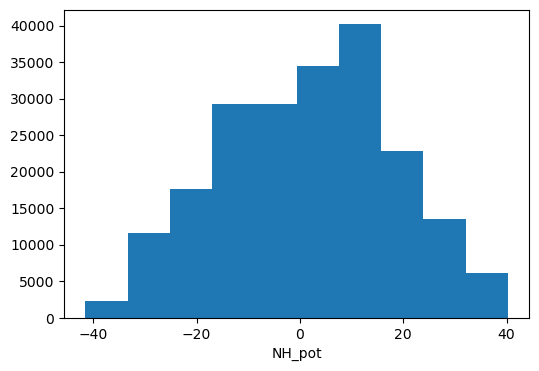

In [108]:
fig, ax = plt.subplots(figsize=(6,4))
NH_ds_E['NH_pot'].plot(ax=ax)

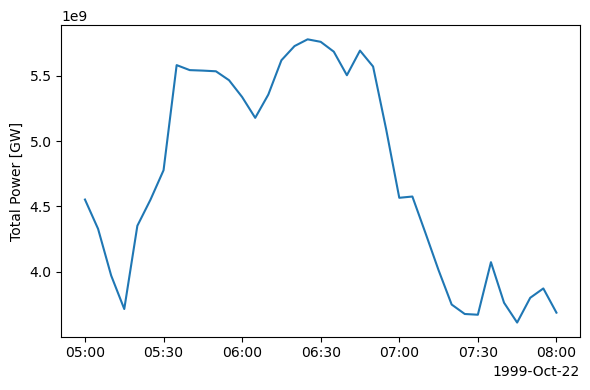

In [103]:
fig, ax = plt.subplots(figsize=(6,4))
NH_ds_E['total_power'].plot(ax=ax)
plt.ylabel('Total Power [GW]')
plt.xlabel(' ')
plt.tight_layout()

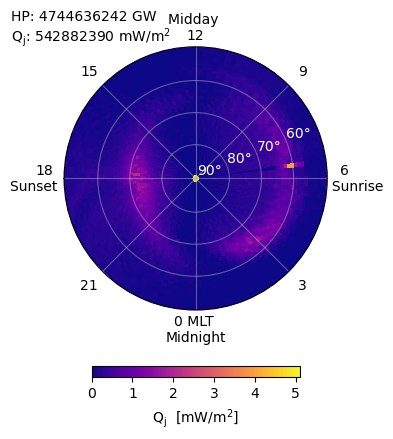

In [104]:
theta = np.linspace(0, 360, 140)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(50, 90, 40)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

shrink = .28
pad = 0.18
t_pad = 10

Qjz = NH_ds_E['Qjx'].mean('dt').values
Qjx = NH_ds_E['Qjx'].mean('dt').values
total_power = NH_ds_E['total_power'].mean('dt').values


#Qjz = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
#Qjx = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
Qj = Qjx + Qjz
Qj_mean = np.max(Qj)

#Ex = ds_E['Qjx'].mean(dim='dt').values
#contour = axs.contourf(theta_rad, r, Qj, cmap='plasma', levels=np.linspace(0,15,100), extend='both')
contour = axs.pcolormesh(theta_rad, r, Qj, cmap='plasma', vmin=0, vmax=5.1)
Qj_label = r'Q$_\mathrm{j}$'
#plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
#plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10])
plt.colorbar(contour, ax=axs, label=f'{Qj_label}  [mW/m$^2$]',pad=0.15,shrink=0.4, orientation='horizontal', ticks=[0,1,2,3,4,5])
#axs.set_ylim([0, 34])

#add total pwoer as text to top left of plot
#plt.annotate(f'{total_power:.2f} GW', xy=(10, 10), xytext=(t_pad, -t_pad), textcoords='offset points', color='black')
#plt.title(f'{total_power:.0f} GW', pad=10, loc='center', color='black')
#title but right aligned not center
#axs.set_title(f'{total_power:.2f} GW', loc='right', pad=10)
axs.annotate(f'HP: {total_power:.0f} GW', xy=(-0.2, 1.1), xycoords='axes fraction',fontsize=10)
axs.annotate(f'{Qj_label}: {Qj_mean:.0f} mW/m$^2$', xy=(-0.2, 1.02), xycoords='axes fraction',fontsize=10)

axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n     Sunrise", "9", "Midday \n12", "15", "18\nSunset     "])
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()